In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import optax
from IPython.display import clear_output

In [4]:
def model(x, a, b):
    return a*x+b

In [5]:
x = np.asarray(100_000)
a = 4.2
b = 0.1

In [18]:
%time y = model(x, a, b)

CPU times: user 394 μs, sys: 156 μs, total: 550 μs
Wall time: 402 μs


In [6]:
def f(x, a, b):
    return a*x+b

def khi2(ydata, ymod, s):
    return (ydata - ymod)**2/s**2

def sumkhi2_old(paramsMod):
    res=0
    i=0
    for x in xs :
        res += khi2(f(x,a,b), paramsMod[0]*x+paramsMod[1], s)
        i += 1
    return res

def sumkhi2(paramsMod):
    return jnp.sum(khi2(f(x,a,b), paramsMod[0]*x+paramsMod[1], s))

def sumkhi2noiseX(paramsMod):
    res=0
    i=0
    for x in xs :
        res += khi2(f(x,a,b), paramsMod[0]*(x+err[i])+paramsMod[1], s)
        i += 1
    return res

def sumkhi2noiseY(paramsMod):
    res=0
    i=0
    for x in xs :
        res += khi2(f(x,a,b)+err[i], paramsMod[0]*x+paramsMod[1], s)
        i += 1
    return res

def minimize(func, x0, step, imax, args=()):
    gradfunc = jax.grad(func)
    guess = jnp.array(x0)
    aguesses = jnp.array([x0[0]]) 
    bguesses = jnp.array([x0[1]])
    i = 0
    while (i != imax):
        grad = gradfunc(guess)
        guess = jnp.add(guess, -step*grad) #guess = jnp.add(guess, -step*(1/(jnp.linalg.norm(grad)-10))*gradient)
        aguesses = jnp.append(aguesses, guess[0].item())
        bguesses = jnp.append(bguesses, guess[1].item())
        i+=1
    print("Final guess : ", guess)
    return aguesses, bguesses, guess

def optaxAdam(func, x0, step, imax, args=()):
    solver = optax.adam(learning_rate=step)
    guess = jnp.array(x0)
    opt_state = solver.init(guess)
    gradfunc = jax.grad(func)
    aguesses = jnp.array([])
    bguesses = jnp.array([])
    for i in range(imax):
        grad = gradfunc(guess)
        updates, opt_state = solver.update(grad, opt_state, guess)
        guess = optax.apply_updates(guess, updates)
        aguesses = jnp.append(aguesses, guess[0].item())
        bguesses = jnp.append(bguesses, guess[1].item())
    print("Final guess : ", guess)
    return aguesses, bguesses, guess

def displayPlot1():
    minAs = jnp.min(jnp.append(aguesses,a-1))
    maxAs = jnp.max(jnp.append(aguesses,a+1))
    minBs = jnp.min(jnp.append(bguesses,b-1))
    maxBs = jnp.max(jnp.append(bguesses,b+1))
    As = np.arange(minAs, maxAs, 0.01)
    Bs = np.arange(minBs, maxBs, 0.01)
    As, Bs = np.meshgrid(As, Bs)
    Ys = sumkhi2([As, Bs])
    
    angle = 0
    while True:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection="3d")   
        ax.set_title("Optimisation par descente de gradient")
        ax.set_xlabel("A")
        ax.set_ylabel("B")
        ax.set_zlabel("sumkhi2 des ...")
        surf = ax.plot_surface(As, Bs, Ys , cmap=matplotlib.cm.coolwarm, linewidth=0, alpha=0.75, antialiased=False)
        ax.scatter(aguesses, bguesses, sumkhi2([aguesses, bguesses]), marker="o", c="#FF00FE", alpha=1)
        ax.scatter(a, b, sumkhi2([a, b]), marker="x", s=70, c="red")
        ax.scatter(fguess[0], fguess[1], sumkhi2(fguess), marker="o", s=50, c="#00DE25")
        ax.legend(["points du plan", "paramètres trouvés au cours de l'optimisation", "vrais paramètres", "derniers paramètres trouvés"])
        ax.view_init(30, angle, 0)
        clear_output(wait=True)
        plt.pause(.001)
        angle = (angle + 1) % 360

def displayPlot2() :
    fig, ax = plt.subplots()
    plt.title("Valeur du loss dans une optimisation par descente de gradient")
    ax.set_xlabel("numéro du pas")
    ax.set_ylabel("sumkhi2 des paramètres trouvés à ce pas")
    steps = np.arange(0, jnp.size(aguesses), 1)
    ax.scatter(steps, sumkhi2([aguesses, bguesses]))

n = 999
a = 9
b = 4
s = 0.2
xs = jnp.array(np.random.uniform(size=n))
err = jnp.array(np.random.normal(0, scale=s, size=n))

#aguesses, bguesses, fguess = minimize(sumkhi2, [8.97, 0.], 0.001, 20)
aguesses, bguesses, fguess = optaxAdam(sumkhi2, [8.97, 0.], 0.1, 600)

Final guess :  [9.00004    0.03004194]


ValueError: Argument Z must be 2-dimensional.

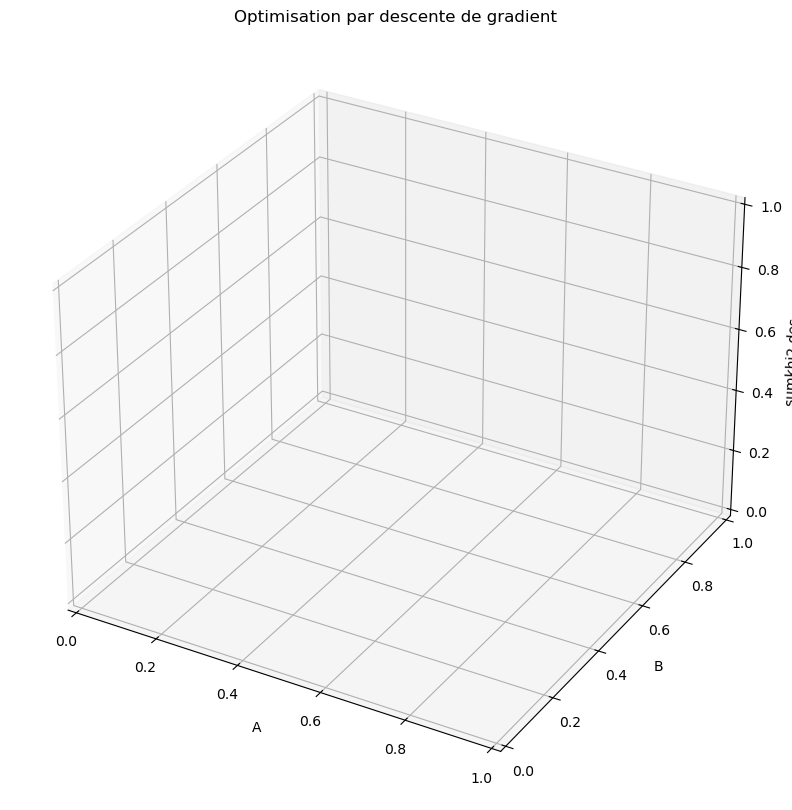

In [7]:
displayPlot1()